In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
class ConvBlock(nn.Module):
    # Convolution Block with Conv2d layer, Batch Normalization and ReLU. Act is an activation function.
    def __init__(
          self,
          in_channels : int,
          out_channels : int,
          kernel_size : int,
          stride : int,
          act = nn.ReLU(),
          groups = 1,
          bn = True,
          bias = False
        ):
        super().__init__()

        # If k = 1 -> p = 0, k = 3 -> p = 1, k = 5, p = 2.
        padding = kernel_size // 2
        self.c = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels) if bn else nn.Identity()
        self.act = act

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.bn(self.c(x)))


In [ ]:
class SeBlock(nn.Module):
    # Squeeze and Excitation Block.
    def __init__(
        self,
        in_channels : int
        ):
        super().__init__()

        C = in_channels
        r = C // 4
        self.globpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(C, r, bias=False)
        self.fc2 = nn.Linear(r, C, bias=False)
        self.relu = nn.ReLU()
        self.hsigmoid = nn.Hardsigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: [N, C, H, W].
        f = self.globpool(x)
        f = torch.flatten(f,1)
        f = self.relu(self.fc1(f))
        f = self.hsigmoid(self.fc2(f))
        f = f[:,:,None,None]
        # f shape: [N, C, 1, 1]

        scale = x * f
        return scale

In [ ]:
  # BNeck
class BNeck(nn.Module):
    # MobileNetV3 Block
    def __init__(
        self,
        in_channels : int,
        out_channels : int,
        kernel_size : int,
        exp_size : int,
        se : bool,
        act : torch.nn.modules.activation,
        stride : int
        ):
        super().__init__()

        self.add = in_channels == out_channels and stride == 1

        self.block = nn.Sequential(
            ConvBlock(in_channels, exp_size, 1, 1, act),
            ConvBlock(exp_size, exp_size, kernel_size, stride, act, exp_size),
            SeBlock(exp_size) if se == True else nn.Identity(),
            ConvBlock(exp_size, out_channels, 1, 1, act=nn.Identity())
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        res = self.block(x)
        if self.add:
            res = res + x

        return res

In [ ]:
""" MobileNetV3 """
class MobileNetV3(nn.Module):
    def __init__(
        self,
        config_name : str,
        in_channels = 3,
        classes = 2
        ):
        super().__init__()
        config = self.config(config_name)

        # First convolution(conv2d) layer.
        self.conv = ConvBlock(in_channels, 16, 3, 2, nn.Hardswish())
        # Bneck blocks in a list.
        self.blocks = nn.ModuleList([])
        for c in config:
            kernel_size, exp_size, in_channels, out_channels, se, nl, s = c
            self.blocks.append(BNeck(in_channels, out_channels, kernel_size, exp_size, se, nl, s))

        # Classifier
        last_outchannel = config[-1][3]
        last_exp = config[-1][1]
        out = 1280 if config_name == "large" else 1024
        self.classifier = nn.Sequential(
            ConvBlock(last_outchannel, last_exp, 1, 1, nn.Hardswish()),
            nn.AdaptiveAvgPool2d((1,1)),
            ConvBlock(last_exp, out, 1, 1, nn.Hardswish(), bn=False, bias=True),
            nn.Dropout(0.8),
            nn.Conv2d(out, classes, 1, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        for block in self.blocks:
            x = block(x)

        x = self.classifier(x)
        return torch.flatten(x, 1)


    def config(self, name):
        HE, RE = nn.Hardswish(), nn.ReLU()
        # [kernel, exp size, in_channels, out_channels, SEBlock(SE), activation function(NL), stride(s)]
        large = [
                [3, 16, 16, 16, False, RE, 1],
                [3, 64, 16, 24, False, RE, 2],
                [3, 72, 24, 24, False, RE, 1],
                [5, 72, 24, 40, True, RE, 2],
                [5, 120, 40, 40, True, RE, 1],
                [5, 120, 40, 40, True, RE, 1],
                [3, 240, 40, 80, False, HE, 2],
                [3, 200, 80, 80, False, HE, 1],
                [3, 184, 80, 80, False, HE, 1],
                [3, 184, 80, 80, False, HE, 1],
                [3, 480, 80, 112, True, HE, 1],
                [3, 672, 112, 112, True, HE, 1],
                [5, 672, 112, 160, True, HE, 2],
                [5, 960, 160, 160, True, HE, 1],
                [5, 960, 160, 160, True, HE, 1]
        ]

        small = [
                [3, 16, 16, 16, True, RE, 2],
                [3, 72, 16, 24, False, RE, 2],
                [3, 88, 24, 24, False, RE, 1],
                [5, 96, 24, 40, True, HE, 2],
                [5, 240, 40, 40, True, HE, 1],
                [5, 240, 40, 40, True, HE, 1],
                [5, 120, 40, 48, True, HE, 1],
                [5, 144, 48, 48, True, HE, 1],
                [5, 288, 48, 96, True, HE, 2],
                [5, 576, 96, 96, True, HE, 1],
                [5, 576, 96, 96, True, HE, 1]
        ]

        if name == "large": return large
        if name == "small": return small

if __name__ == "__main__":
    name = "large"
    rho = 1
    res = int(rho * 224)

    net = MobileNetV3(name)
    print(net(torch.rand(1, 3, res, res)).shape)

torch.Size([1, 2])


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

data_transforms_res = transforms.Compose([
    transforms.Resize((224,224)), # Resize images to 224,224 pixels, adjusted for MobileNetV3
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

combined_data_dir = '/content/drive/MyDrive/autism/combined_dataset'
# Load the augmented data into a dataset
combined_dataset = ImageFolder(combined_data_dir, transform=data_transforms_res)

# Define the lengths of the training and validation sets
train_size = len(combined_dataset)
validation_size = int(train_size * 0.2) # 20% of the data for validation
train_size = train_size - validation_size # Adjust the training size

# Split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(combined_dataset, [train_size, validation_size])

# Create DataLoaders for the training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=2)

# Update the dataset_sizes dictionary to include the validation set
dataset_sizes = {
    'train': train_size,
    'validation': validation_size
}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_save_path = '/content/drive/MyDrive/SpectrumSense/Model_checkpoints/MobileNET_V3/Mobilenet_V3_100epochs.pth'
checkpoint_exists = os.path.isfile(model_save_path)

# Initializing the model
model = MobileNetV3(config_name="small")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)  # Adjust parameters as needed

# Load the checkpoint if it exists
if checkpoint_exists:
    checkpoint = torch.load(model_save_path, map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    last_loss = checkpoint['loss']
else:
    # If the checkpoint does not exist, initialize the last epoch and loss
    last_epoch = 0
    last_loss = 0.0

model = model.to(device)

num_epochs = 100
early_stop_epochs = 15  # Number of epochs to wait for early stopping
best_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(last_epoch + 1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Use the appropriate DataLoader based on the phase
        if phase == 'train':
            dataloader = train_dataloader
        else:
            dataloader = validation_dataloader

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Check for early stopping based on validation loss
        if phase == 'validation':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= early_stop_epochs:
                print('Early stopping triggered! No improvement in validation loss for {} epochs.'.format(
                    epochs_without_improvement))
                break  # Exit training loop

    # Save the model state after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
        'accuracy': epoch_acc,
    }, model_save_path)

    if epochs_without_improvement >= early_stop_epochs:
        break  # Exit epoch loop if early stopping triggered

    # Step the learning rate scheduler
    scheduler.step()

print('Training complete')


Epoch 1/100
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 0.6708 Acc: 0.5906
validation Loss: 0.6704 Acc: 0.5496
Epoch 2/100
----------
train Loss: 0.6243 Acc: 0.6463
validation Loss: 0.6493 Acc: 0.6154
Epoch 3/100
----------
train Loss: 0.6134 Acc: 0.6685
validation Loss: 0.6130 Acc: 0.6419
Epoch 4/100
----------
train Loss: 0.6119 Acc: 0.6630
validation Loss: 0.6257 Acc: 0.6385
Epoch 5/100
----------
train Loss: 0.6094 Acc: 0.6664
validation Loss: 0.6269 Acc: 0.6436
Epoch 6/100
----------
train Loss: 0.6155 Acc: 0.6645
validation Loss: 0.5975 Acc: 0.6718
Epoch 7/100
----------
train Loss: 0.6191 Acc: 0.6632
validation Loss: 0.6290 Acc: 0.6632
Epoch 8/100
----------
train Loss: 0.6024 Acc: 0.6835
validation Loss: 0.5802 Acc: 0.7060
Epoch 9/100
----------
train Loss: 0.5805 Acc: 0.6991
validation Loss: 0.5589 Acc: 0.7239
Epoch 10/100
----------
train Loss: 0.5743 Acc: 0.7008
validation Loss: 0.5591 Acc: 0.7026
Epoch 11/100
----------
train Loss: 0.5717 Acc: 0.7008
validation Loss: 0.5545 Acc: 0.7205
Epoch 12/100
----------
train L

Precision: 0.9081632653061225
Recall: 0.89
F1-score: 0.8989898989898989
Accuracy: 0.9
Confusion Matrix:
Specificity: 0.91
[[91  9]
 [11 89]]


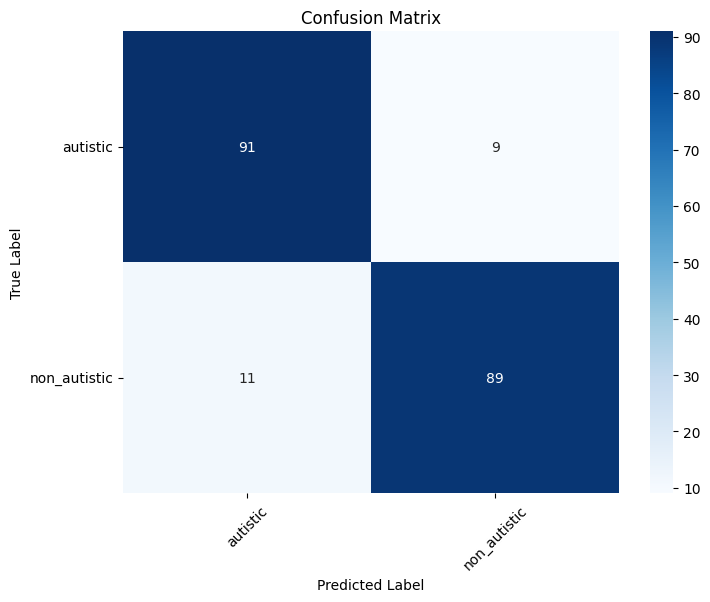

In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the transforms for evaluation
data_transforms_res = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.CenterCrop(224),      # Center crop
    transforms.ToTensor(),           # Convert to tensor
])

# Load the dataset for evaluation
eval_dataset = ImageFolder('/content/drive/MyDrive/autism/test', transform=data_transforms_res)

# Create DataLoader for evaluation
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

# Load the MobileNetV3 model
model = MobileNetV3(config_name="small")
checkpoint = torch.load('/content/drive/MyDrive/SpectrumSense/Model_checkpoints/MobileNET_V3/Mobilenet_V3_100epochs.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize lists to store predictions and ground truth labels
all_preds = []
all_labels = []

# Iterate over the evaluation dataset
for inputs, labels in eval_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)

    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print("Specificity:", specificity)
print(conf_matrix)
classes = eval_dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import torch.nn.functional as F

model_save_path = '/content/drive/MyDrive/SpectrumSense/Model_checkpoints/MobileNET_V3/Mobilenet_V3_100epochs.pth'

# Path to the test image
test_image_path = '/content/drive/MyDrive/autism/test/autistic/025.jpg'


#ASK ME BEFORE RUNNING THIS CODE
data_transforms_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

model = MobileNetV3(config_name="small")

checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() # Set the model to evaluation mode
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Load and transform the test image
image = Image.open(test_image_path)
image = data_transforms_test(image).unsqueeze(0)

# Make a prediction
with torch.no_grad():
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)
    _, preds = torch.max(probabilities, 1)

class_names = ['Not Autistic', 'Autistic']

# Predicted class name
predicted_class = class_names[preds.item()]

# Print the probabilities of confidence rate for each class
print(f'Predicted class: {predicted_class}')
print(f'Probabilities: {probabilities.tolist()}')